# Polygon Coloring Inference Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import sys
sys.path.append("/content/drive/MyDrive/code")
from Unet import ConditionalUNet
from Utils import load_and_preprocess_image, create_color_condition, tensor_to_pil, denormalize_image


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Load Trained Model

Load the best trained model from the checkpoint.

In [ ]:
# Load the best checkpoint
checkpoint_path = '/content/drive/MyDrive/code/best_checkpoint.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Extract model configuration and color info
config = checkpoint['config']
color_info = checkpoint['color_info']

print(f"Model configuration: {config['model_type']}")
print(f"Available colors: {color_info['colors']}")
print(f"Color mapping: {color_info['color_to_idx']}")

# Initialize model
if config['model_type'] == 'film':
    model = ConditionalUNet(
        num_colors=color_info['num_colors'],
        n_channels=config['n_channels'],
        n_classes=config['n_classes'],
        color_embed_dim=config.get('color_embed_dim', 128),
        bilinear=config.get('bilinear', True)
    )
else:
    model = AlternativeConditionalUNet(
        num_colors=color_info['num_colors'],
        n_channels=config['n_channels'],
        n_classes=config['n_classes'],
        bilinear=config.get('bilinear', True)
    )

# Load model weights
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Training completed at epoch {checkpoint['epoch']}")
print(f"Best validation loss: {checkpoint['best_val_loss']:.4f}")

Model configuration: film
Available colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']
Color mapping: {'blue': 0, 'cyan': 1, 'green': 2, 'magenta': 3, 'orange': 4, 'purple': 5, 'red': 6, 'yellow': 7}
Model loaded successfully!
Training completed at epoch 70
Best validation loss: 0.1094


## Display Available Colors

Let's visualize all the available colors that the model can generate.

In [ ]:
def infer_single_image(model, image_path, color_name, color_to_idx, device='cpu', image_size=256):
    """
    Perform inference on a single image.

    Args:
        model: Trained model
        image_path: Path to input polygon image
        color_name: Name of the desired color
        color_to_idx: Color to index mapping
        device: Device to run inference on
        image_size: Size to resize image to

    Returns:
        input_image, predicted_image (as PIL Images)
    """
    # Load and preprocess input image
    input_tensor = load_and_preprocess_image(image_path, image_size).to(device)

    # Create color condition
    color_condition = create_color_condition(color_name, color_to_idx).to(device)

    # Perform inference
    with torch.no_grad():
        predicted_tensor = model(input_tensor, color_condition)

    # Convert tensors to PIL images
    input_pil = tensor_to_pil(denormalize_image(input_tensor[0]))
    predicted_pil = tensor_to_pil(denormalize_image(predicted_tensor[0]))

    return input_pil, predicted_pil


def visualize_inference(input_pil, predicted_pil, color_name, polygon_name):
    """
    Visualize inference results.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Input image
    axes[0].imshow(input_pil)
    axes[0].set_title(f'Input: {polygon_name}')
    axes[0].axis('off')

    # Predicted image
    axes[1].imshow(predicted_pil)
    axes[1].set_title(f'Generated: {color_name.capitalize()} {polygon_name}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

## Test Inference on Sample Images

Let's test the model on some sample images from the validation set.

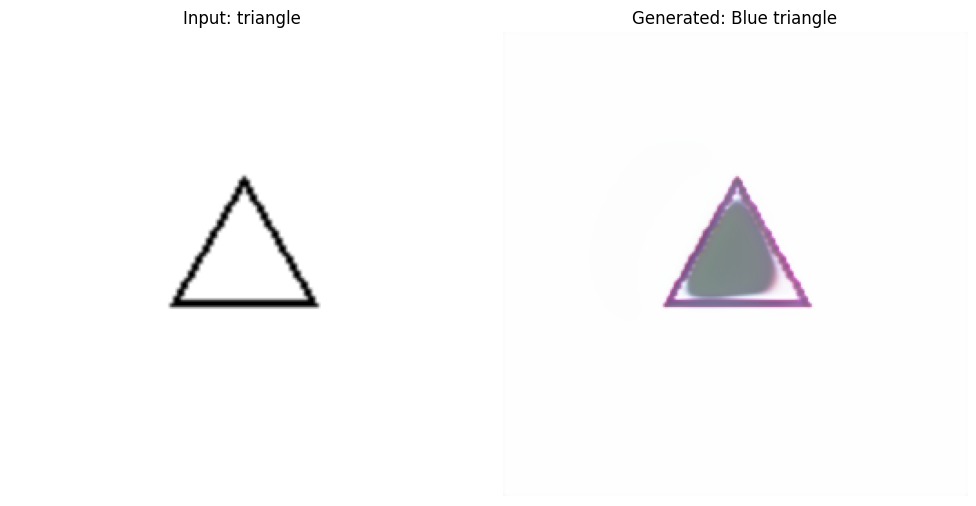

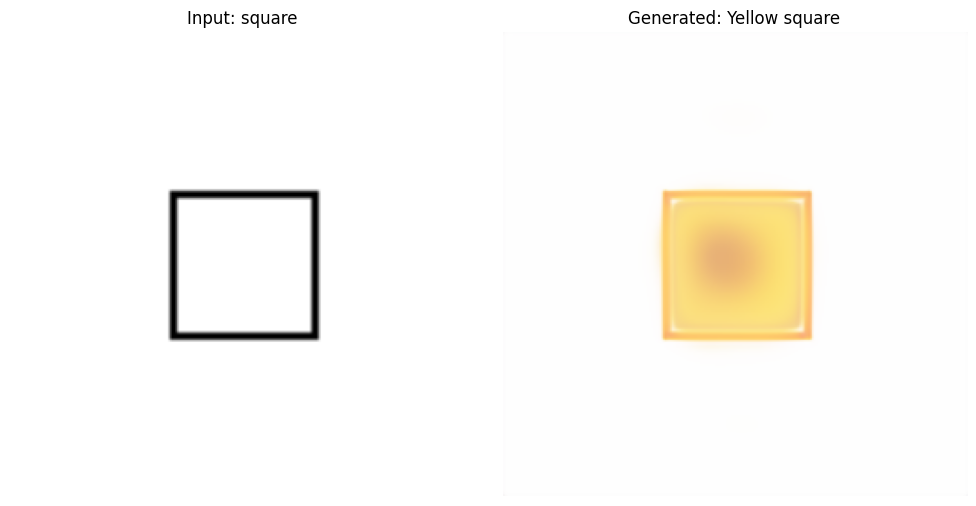

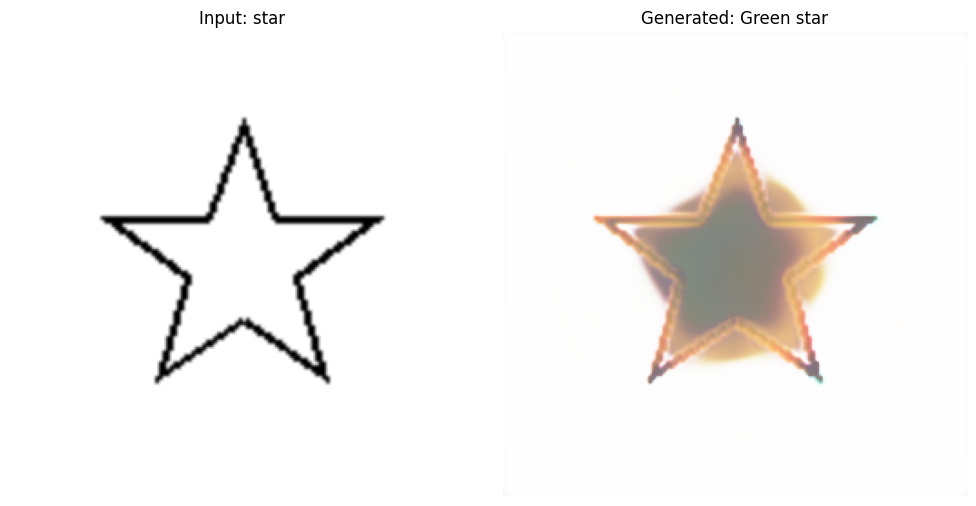

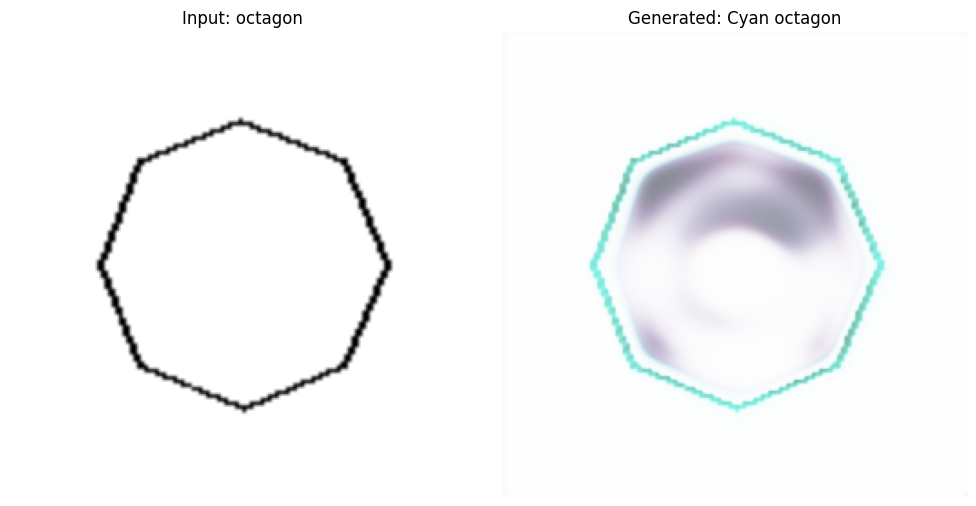

In [ ]:
# Define test examples
test_examples = [
    {'polygon': 'triangle.png', 'color': 'blue', 'description': 'blue Triangle'},
    {'polygon': 'square.png', 'color': 'yellow', 'description': 'yellow Square'},
    {'polygon': 'star.png', 'color': 'green', 'description': 'green Star'},
    {'polygon': 'octagon.png', 'color': 'cyan', 'description': 'Cyan Octagon'},
]

# Input directory (modify path as needed)
input_dir = '/content/drive/MyDrive/dataset/dataset/validation/inputs'

# Test each example
for example in test_examples:
    polygon_path = os.path.join(input_dir, example['polygon'])

    if os.path.exists(polygon_path):
        try:
            # Perform inference
            input_pil, predicted_pil = infer_single_image(
                model, polygon_path, example['color'],
                color_info['color_to_idx'], device
            )

            # Visualize results
            visualize_inference(
                input_pil, predicted_pil,
                example['color'], example['polygon'].replace('.png', '')
            )

        except Exception as e:
            print(f"Error processing {example['polygon']} with {example['color']}: {e}")
    else:
        print(f"File not found: {polygon_path}")

## Interactive Color Testing

Test the same polygon with different colors to see how the model handles color variations.

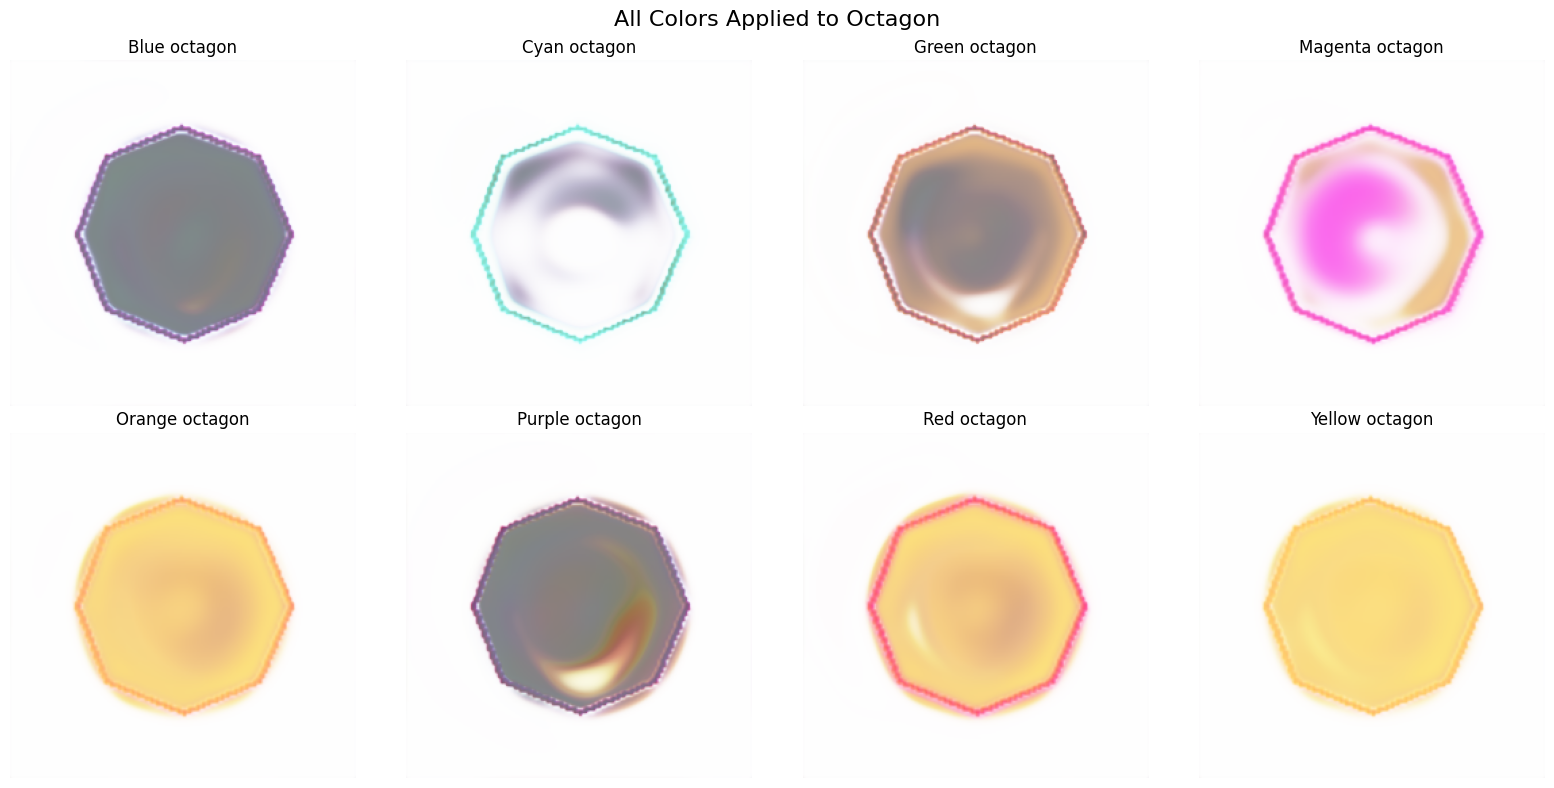

In [ ]:
# Choose a polygon to test with different colors
test_polygon = 'octagon.png'  # Change this to test different polygons
polygon_path = os.path.join(input_dir, test_polygon)

if os.path.exists(polygon_path):
    # Test with all available colors
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, color in enumerate(color_info['colors']):
        try:
            # Perform inference
            input_pil, predicted_pil = infer_single_image(
                model, polygon_path, color,
                color_info['color_to_idx'], device
            )

            # Display result
            axes[i].imshow(predicted_pil)
            axes[i].set_title(f'{color.capitalize()} {test_polygon.replace(".png", "")}')
            axes[i].axis('off')

        except Exception as e:
            print(f"Error with {color}: {e}")
            axes[i].text(0.5, 0.5, f'Error\n{color}',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')

    plt.suptitle(f'All Colors Applied to {test_polygon.replace(".png", "").capitalize()}', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print(f"File not found: {polygon_path}")

## Model Performance Analysis

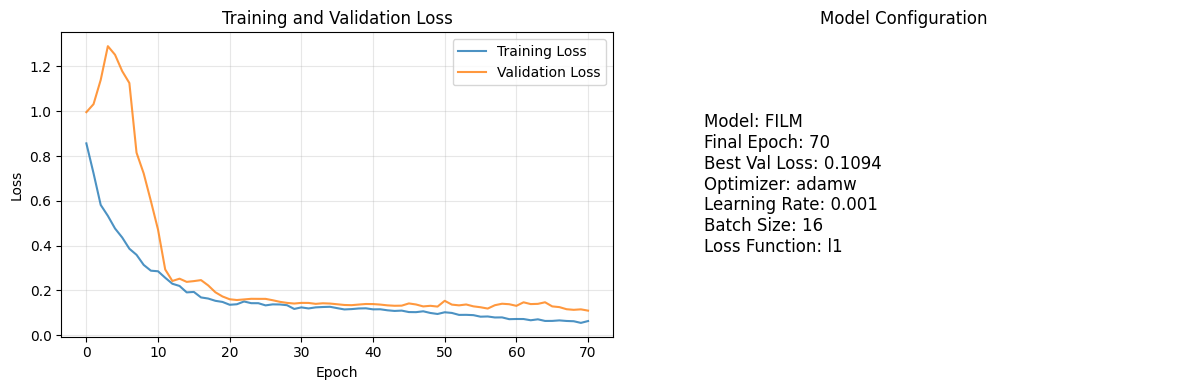

In [ ]:
# Display training curves from the checkpoint
if 'train_losses' in checkpoint and 'val_losses' in checkpoint:
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']

    plt.figure(figsize=(12, 4))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', alpha=0.8)
    plt.plot(val_losses, label='Validation Loss', alpha=0.8)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Model info
    plt.subplot(1, 2, 2)
    info_text = f"""
    Model: {config['model_type'].upper()}
    Final Epoch: {checkpoint['epoch']}
    Best Val Loss: {checkpoint['best_val_loss']:.4f}
    Optimizer: {config.get('optimizer', 'N/A')}
    Learning Rate: {config.get('learning_rate', 'N/A')}
    Batch Size: {config.get('batch_size', 'N/A')}
    Loss Function: {config.get('loss_function', 'N/A')}
    """
    plt.text(0.1, 0.5, info_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='center')
    plt.axis('off')
    plt.title('Model Configuration')

    plt.tight_layout()
    plt.show()
else:
    print("Training history not available in checkpoint.")